In [1]:

import os
os.environ['KERAS_BACKEND'] = 'torch'

import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import List
import torch
import keras
import xarray as xr
from src.EEGModalNet import WGAN_GP_old
from scipy.signal import butter, sosfiltfilt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers, layers

In [2]:
# PARAMS

DATA_PATH = 'data/LEMON_DATA/EC_all_channels_processed_downsampled.nc5'
DEMOGRAPHICS_PATH = 'data/LEMON_DATA/Demographics.csv'
PRETRAINED_CHECKPOINT_PATH = 'logs/06022025/06.02.2025_epoch_2500.model.keras'
CLS_CHECKPOINT_PATH = 'logs/20250221_classifier_v3'

CHANNELS = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

DO_GROUPED_SHUFFLE = True
DO_DOWN_SAMPLE = True

In [8]:

def load_data(data_path: str,
              channels: List[str],
              bandpass_filter: float = .5,
              time_dim: int = 512) -> tuple:

    xarray = xr.open_dataarray(data_path, engine='h5netcdf')
    n_subjects = xarray.subject.size

    demog = pd.read_csv(DEMOGRAPHICS_PATH, index_col="ID")

    # behavioral score    
    beh_score = pd.read_csv('data/LEMON_DATA/UPPS.csv', index_col="ID")
    beh_score_name = 'UPPS_sens_seek'
    beh_score[beh_score_name] = (
        beh_score[beh_score_name].apply(
            lambda x: 1 if x > 30 else 0))

    # merge behavioral score
    demog = demog.merge(beh_score, left_index=True, right_index=True)
    beh_score = demog.loc[xarray["subject"].values, beh_score_name]
    xarray = xarray.assign_coords(beh_score=("subject", beh_score))

    # age (young/old)
    demog['is_old'] = demog['Age'].apply(lambda x:
        1 if int(x.split('-')[0]) >= 50 else 0)
    beh_score = demog.loc[xarray["subject"].values, "is_old"]
    xarray = xarray.assign_coords(beh_score=("subject", beh_score))

    if DO_DOWN_SAMPLE:
        n_y0 = (beh_score == 0).sum()
        n_y1 = (beh_score == 1).sum()
        n_min = min(n_y0, n_y1)
        n_subjects = n_min * 2
        y0_sub_ids = beh_score[beh_score == 0].index[:n_min]
        y1_sub_ids = beh_score[beh_score == 1].index[:n_min]
        sub_ids = y0_sub_ids.append(y1_sub_ids)
        xarray = xarray.sel(subject=sub_ids)

    x = xarray.sel(channel=channels)

    x = x.to_numpy()
    # n_subjects = x.shape[0]

    if bandpass_filter is not None:
        sos = butter(4, bandpass_filter, btype='high', fs=128, output='sos')  # TODO: fs
        x = sosfiltfilt(sos, x, axis=-1)

    x = torch.tensor(x.copy()).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)  # TODO: copy was added because of an error, look into this

    sub = torch.tensor(np.arange(0, n_subjects).repeat(x.shape[0] // n_subjects)[:, np.newaxis])
    labels = xarray.beh_score.values

    y = labels.repeat(x.shape[0] / n_subjects)
    sub_ids_classifier = sub.squeeze().numpy()

    return x, y, sub_ids_classifier

X_input, y, groups = load_data(DATA_PATH, CHANNELS)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {'0': class_weights[0], '1': class_weights[1]}

print(X_input.shape, y.shape, np.unique(groups).shape)
print(class_weights)

torch.Size([11830, 512, 8]) (11830,) (130,)
{'0': np.float64(1.0), '1': np.float64(1.0)}


In [4]:
# LOAD MODEL AND EXTRACT X_EMBEDDING (X_e and X_e_subj)

keras.utils.clear_session(free_memory=True)

model = WGAN_GP_old(time_dim=512, feature_dim=len(CHANNELS),
                    latent_dim=128, n_subjects=202,
                    use_sublayer_generator=True,
                    use_sublayer_critic=True,
                    use_channel_merger_g=False,
                    use_channel_merger_c=False,
                    interpolation='bilinear')

model.load_weights(PRETRAINED_CHECKPOINT_PATH)


X_input_subj = model.critic.get_layer('torch_module_wrapper_1')(
    X_input.float().to('mps'),
    torch.tensor(groups).to('mps'))

X_e = model.critic.model.get_layer('dis_flatten')(X_input)
# X_e = model.critic.model.get_layer('dis_flatten')(X_input_subj)
X_e = X_e.detach().cpu()

In [9]:
# SPLIT

if DO_GROUPED_SHUFFLE:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
    train_idx, val_idx = next(group_shuffle.split(X_e, y, groups=groups))
else:
    random_shuffle = ShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
    train_idx, val_idx = next(random_shuffle.split(X_e, y))

y.mean(), y[train_idx].mean(), y[val_idx].mean()

(np.float64(0.5),
 np.float64(0.4945054945054945),
 np.float64(0.5128205128205128))

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(f'{CLS_CHECKPOINT_PATH}.model.keras', monitor='val_accuracy', save_best_only=True),
    keras.callbacks.CSVLogger(f'{CLS_CHECKPOINT_PATH}.csv'),
    keras.callbacks.TerminateOnNaN()
]

cls_model = keras.models.Sequential([   
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

def smoothed_binary_crossentropy(epsilon=0.1): # Epsilon controls smoothing
    def loss(y_true, y_pred):
        y_true_smoothed = y_true * (1.0 - epsilon) + 0.5 * epsilon # Soften labels
        return keras.losses.binary_crossentropy(y_true_smoothed, y_pred)
    return loss


cls_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    # loss=keras.losses.Hinge(),
    # loss=smoothed_binary_crossentropy(),
    # loss='mse',
    # loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'])

history = cls_model.fit(
    X_e[train_idx], y[train_idx],
    epochs=1000,
    batch_size=20000,
    validation_data=(X_e[val_idx], y[val_idx]),
    callbacks=callbacks,
    class_weight=class_weights,
    shuffle=True)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{CLS_CHECKPOINT_PATH}_final.csv')
cls_model.save(f'{CLS_CHECKPOINT_PATH}_final.model.keras')

clear_output(wait=True)
print('Training finished!')

Training finished!


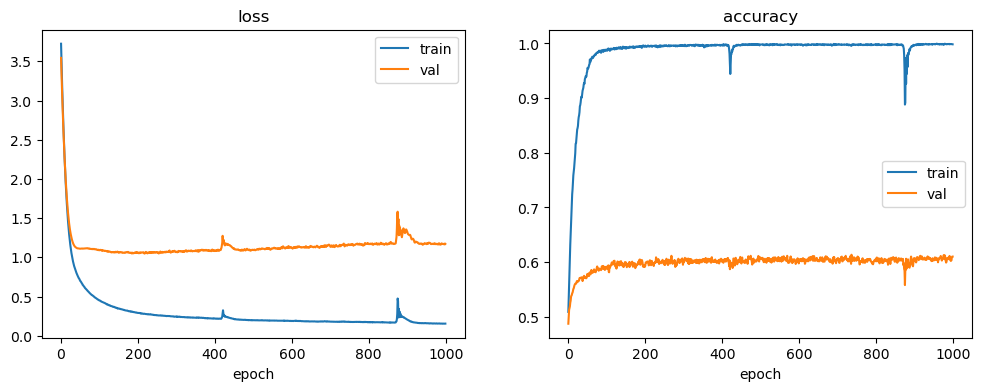

In [11]:
# PLOTTING LOSS AND ACCURACY

def plot_history(history_df):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='train')
    plt.plot(history_df['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('loss')

    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='train')
    plt.plot(history_df['val_accuracy'], label='val')
    plt.legend()
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.show()

plot_history(history_df)